In [2]:
import os
from functools import partial

os.environ["JAX_ENABLE_X64"] = "True"

import jax.numpy as jnp
import typer
from jax import Array, jit, random, vmap
from jax._src.prng import PRNGKeyArray

from bpd import DATA_DIR
from bpd.draw import draw_gaussian, draw_spergel
from bpd.io import save_dataset
from bpd.likelihood import gaussian_image_loglikelihood
from bpd.pipelines import pipeline_interim_samples_one_galaxy
from bpd.prior import interim_gprops_logprior
from bpd.sample import (
    get_target_images,
    get_true_params_from_galaxy_params,
    sample_galaxy_params_skew,
)
from bpd.utils import DEFAULT_HYPERPARAMS, MAX_N_GALS_PER_GPU, process_in_batches


In [3]:
def _init_fnc(key: PRNGKeyArray, *, data: Array, true_params: dict):
    image = data
    assert image.ndim == 2
    assert image.shape[0] == image.shape[1]
    flux = image.sum()

    k1, k2, k3 = random.split(key, 3)

    tlhlr = true_params["lhlr"]
    lhlr = random.uniform(k1, shape=(), minval=tlhlr - 0.015, maxval=tlhlr + 0.015)

    te1 = true_params["e1"]
    e1 = random.uniform(k2, shape=(), minval=te1 - 0.1, maxval=te1 + 0.1)

    te2 = true_params["e2"]
    e2 = random.uniform(k3, shape=(), minval=te2 - 0.1, maxval=te2 + 0.1)
    return {
        "lf": jnp.log10(flux),
        "lhlr": lhlr,
        "e1": e1,
        "e2": e2,
        "dx": 0.0,
        "dy": 0.0,
    }

In [3]:
seed: int = 11
n_gals: int = 100
n_samples_per_gal: int = 100
sigma_e_int: float = 0.3
g1: float = 0.02
g2: float = 0.0
slen: int = 63
fft_size: int = 256
background: float = 1.0
initial_step_size: float = 0.01


In [4]:
rng_key = random.key(seed)
pkey, nkey, gkey = random.split(rng_key, 3)



# galaxy parameters from prior
galaxy_params = sample_galaxy_params_skew(
    pkey, n=n_gals, g1=g1, g2=g2, **DEFAULT_HYPERPARAMS
)
assert galaxy_params["x"].shape == (n_gals,)
assert galaxy_params["e1"].shape == (n_gals,)

In [5]:
# now get corresponding target images
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
draw_params["hlr"] = 10 ** draw_params.pop("lhlr")
target_images = get_target_images(
    nkey,
    draw_params,
    background=background,
    slen=slen,
    draw_type="exponential",
)
assert target_images.shape == (n_gals, slen, slen)

# interim samples are on 'sheared ellipticity'
true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)
true_params["dx"] = jnp.zeros_like(true_params["x"])
true_params["dy"] = jnp.zeros_like(true_params["y"])
fixed_params = {
    "x": true_params.pop("x"),
    "y": true_params.pop("y"),
}

In [6]:
# setup prior and likelihood
_logprior = partial(
    interim_gprops_logprior,
    sigma_e=sigma_e_int,
    free_flux_hlr=True,
    free_dxdy=True,
)
_draw_fnc = partial(draw_spergel, nu=0.5, slen=slen, fft_size=fft_size) # need to specify nu
_loglikelihood = partial(
    gaussian_image_loglikelihood,
    draw_fnc=_draw_fnc,
    background=background,
    free_flux_hlr=True,
    free_dxdy=True,
)

# prepare pipelines
gkeys = random.split(gkey, n_gals)
pipe = partial(
    pipeline_interim_samples_one_galaxy,
    initialization_fnc=_init_fnc,
    logprior=_logprior,
    loglikelihood=_loglikelihood,
    n_samples=n_samples_per_gal,
    initial_step_size=initial_step_size,
)
vpipe = vmap(jit(pipe))

In [7]:
# compilation on single target image
_ = vpipe(
    gkeys[0, None],
    target_images[0, None],
    {k: v[0, None] for k, v in fixed_params.items()},
    {k: v[0, None] for k, v in true_params.items()},
)

In [8]:
samples = process_in_batches(
    vpipe,
    gkeys,
    target_images,
    fixed_params,
    true_params,
    n_points=n_gals,
    batch_size=100,
)

Processing batches: 100%|██████████| 1/1 [00:53<00:00, 53.08s/it]


In [9]:
samples['e1'].shape

(100, 100)

# Check runs on SLURM (test)

In [20]:
from bpd.io import load_dataset
import matplotlib.pyplot as plt

In [12]:
fpath = "/pscratch/sd/i/imendoza/data/cache_chains/exp93_51/interim_samples_99100_plus.npz"

In [14]:
ds = load_dataset(fpath)

In [16]:
ds.keys()

dict_keys(['samples', 'truth', 'hyper'])

In [17]:
ds['hyper']

{'g1': array(0.02),
 'g2': array(0.),
 'sigma_e_int': array(0.3),
 'nu': array(0.1),
 'shape_noise': array(0.2),
 'a_logflux': array(14.),
 'mean_logflux': array(2.45),
 'sigma_logflux': array(0.4),
 'mean_loghlr': array(-0.4),
 'sigma_loghlr': array(0.05)}

In [18]:
ds['samples']['e1'].shape

(1000, 300)

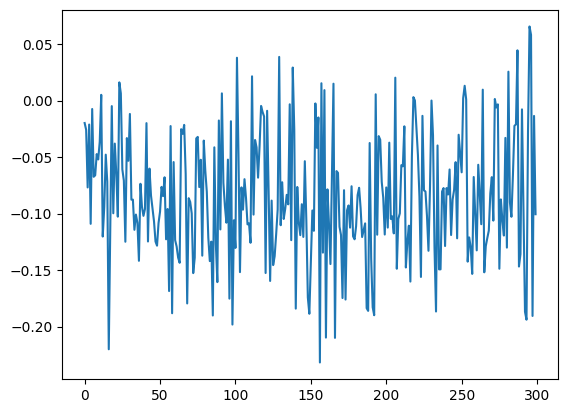

In [37]:
plt.plot(ds['samples']['dy'][11, :])

# Check large run in SLURM

In [7]:
from bpd.io import load_dataset
import matplotlib.pyplot as plt

fpath = "/pscratch/sd/i/imendoza/data/cache_chains/exp93_51/interim_samples_51152_minus_nu50.npz"
ds = load_dataset(fpath)

In [8]:
ds['samples']['e1'].shape, ds['hyper']['nu'], ds['hyper']['g1']

((10000, 300), array(0.5), array(-0.02))

In [9]:
from matplotlib.backends.backend_pdf import PdfPages


fname = "traces1.pdf"
with PdfPages(fname) as pdf:
    for ii in range(25):
        fig, ax = plt.subplots(1, 1, figsize=(12,7))
        ax.plot(ds['samples']['e1'][ii])
        pdf.savefig(fig)
        plt.close(fig)

In [13]:
# compare with no model bias case

fpath = "/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/interim_samples_511_plus.npz"
ds2 = load_dataset(fpath)


In [14]:
from matplotlib.backends.backend_pdf import PdfPages


fname = "traces2.pdf"
with PdfPages(fname) as pdf:
    for ii in range(25):
        fig, ax = plt.subplots(1, 1, figsize=(12,7))
        ax.plot(ds2['samples']['e1'][ii])
        pdf.savefig(fig)
        plt.close(fig)

# Check shear 

In [1]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["JAX_ENABLE_X64"] = "True"
import matplotlib.pyplot as plt


from bpd.io import load_dataset

In [2]:
dsp = load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/exp93_51/g_samples_512_plus_nu50.npz")
dsm = load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/exp93_51/g_samples_512_minus_nu50.npz")


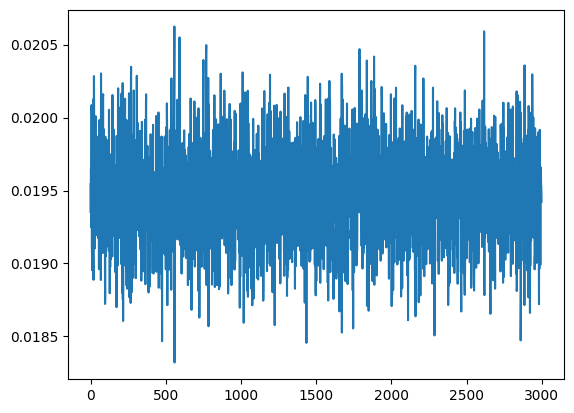

In [3]:
plt.plot(dsp['samples']['g1'])

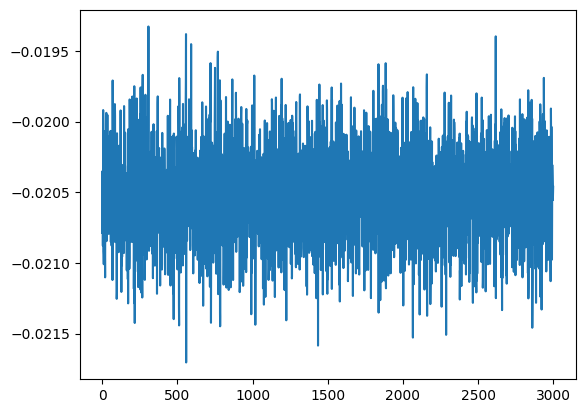

In [4]:
plt.plot(dsm['samples']['g1'])

In [5]:
g1p = dsp['samples']['g1']
g1m = dsm['samples']['g1']
g1p.shape

(3000,)

In [6]:
m = (g1p.mean() - g1m.mean()) / 2/ 0.02 -1 
m

np.float64(-0.00018929439224490974)

 # Check boots


In [1]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["JAX_ENABLE_X64"] = "True"
import matplotlib.pyplot as plt


from bpd.io import load_dataset

In [3]:
ds = load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/exp93_51/g_samples_boots_513_nu50.npz")



In [6]:
g1p =ds['plus']['g1']
g1m = ds['minus']['g1']
g1p.shape

(100, 1000)

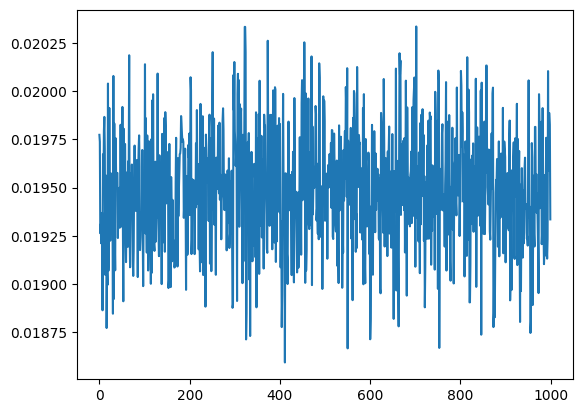

In [5]:
plt.plot(g1p[1])

(array([ 1.,  1.,  6., 11., 15., 18., 22., 10., 10.,  6.]),
 array([0.01839116, 0.01857487, 0.01875858, 0.01894229, 0.01912601,
        0.01930972, 0.01949343, 0.01967715, 0.01986086, 0.02004457,
        0.02022828]),
 <BarContainer object of 10 artists>)

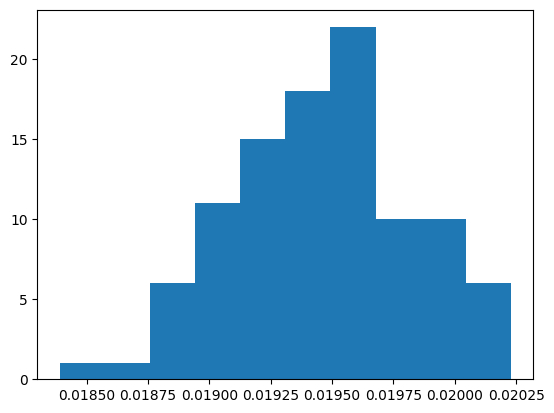

In [7]:
plt.hist(g1p.mean(1))

In [9]:
ms = (g1p.mean(1) - g1m.mean(1)) / 2/ 0.02 -1
ms.shape

(100,)

(array([ 4.,  3., 11., 10., 21., 20., 20.,  6.,  4.,  1.]),
 array([-6.58358806e-04, -5.48208027e-04, -4.38057248e-04, -3.27906469e-04,
        -2.17755691e-04, -1.07604912e-04,  2.54586680e-06,  1.12696646e-04,
         2.22847424e-04,  3.32998203e-04,  4.43148982e-04]),
 <BarContainer object of 10 artists>)

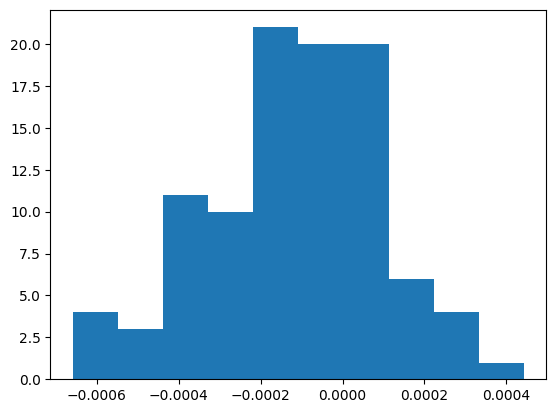

In [10]:
plt.hist(ms)

In [12]:
ms.mean(), ms.std()

(np.float64(-0.00011957386798073011), np.float64(0.00022498552873866418))

# Combine all experiments

In [1]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["JAX_ENABLE_X64"] = "True"
import matplotlib.pyplot as plt


from bpd.io import load_dataset

In [10]:
_nu_hash = {
    -0.6: "-60",
    -0.4: "-40",
    -0.2: "-20",
    0.1: "10",
    0.3: "30",
    0.5: "50",
    1.0: "100",
    2.0: "200",
    3.0: "300",
}

nus = [k for k,v in _nu_hash.items()]
nus_str = [v for k,v in _nu_hash.items()]

In [11]:
nus, nus_str

([-0.6, -0.4, -0.2, 0.1, 0.3, 0.5, 1.0, 2.0, 3.0],
 ['-60', '-40', '-20', '10', '30', '50', '100', '200', '300'])

In [12]:
ms = []
for nu in nus_str:
    dsp = load_dataset(f"/pscratch/sd/i/imendoza/data/cache_chains/exp93_51/g_samples_512_plus_nu{nu}.npz")
    dsm = load_dataset(f"/pscratch/sd/i/imendoza/data/cache_chains/exp93_51/g_samples_512_minus_nu{nu}.npz")


    g1p = dsp['samples']['g1']
    g1m = dsm['samples']['g1']

    m = (g1p.mean() - g1m.mean()) / 2 / 0.02 - 1
    ms.append(m)

In [19]:
# gaussian
dsp = load_dataset(f"/pscratch/sd/i/imendoza/data/cache_chains/exp91_51/g_samples_512_plus.npz")
dsm = load_dataset(f"/pscratch/sd/i/imendoza/data/cache_chains/exp91_51/g_samples_512_minus.npz")

g1p = dsp['samples']['g1']
g1m = dsm['samples']['g1']
m_gauss = (g1p.mean() - g1m.mean()) / 2 / 0.02 - 1


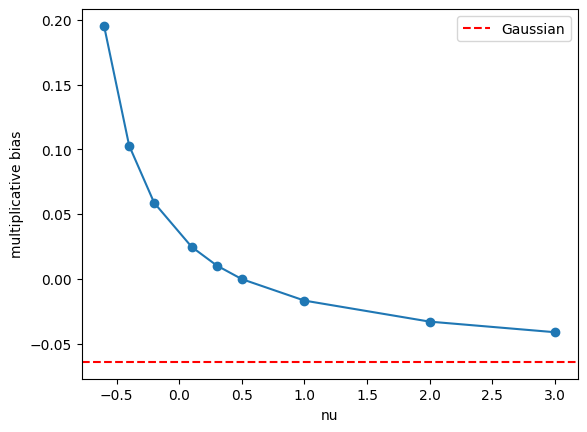

In [21]:
plt.plot(nus, ms, '-o')
plt.ylabel('multiplicative bias')
# plt.axhline(2e-3, c='k', ls='--')
# plt.axhline(-2e-3, c='k', ls='--', label='requirement')
plt.xlabel('nu')
plt.axhline(m_gauss, c='r', ls='--', label='Gaussian')
plt.legend()